# Link to the full notebook: https://nbviewer.org/github/beridzeg45/Exploratory-Data-Analysis-with-Python/blob/main/US%20Presidential%20Election%20Analysis%20%28Geopandas%2C%20Plotly%29.ipynb

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.options.display.max_columns=100
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time

df=pd.read_csv(r"C:\Users\berid\python\csv_files\us elections\1976-2020-president.csv")
states=geopandas.read_file(r"C:\Users\berid\python\geopandas\s_22mr22_states\s_22mr22.shp")
world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

CPU times: total: 8.83 s
Wall time: 12.6 s


In [3]:
df

year    state state_po  state_fips  state_cen  state_ic        office  \
0     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
1     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
2     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
3     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
4     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
...    ...      ...      ...         ...        ...       ...           ...   
4282  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4283  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4284  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4285  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4286  2020  WYOMING       WY          56         83        68  US PRESIDENT   

                    candidate              party_detailed writein  \
0               CARTER, JIMMY                    DEMOCRAT   False   
1                FORD, GERALD                  REPUBLICAN   False   
2              MADDOX, LESTER  AMERICAN INDEPENDENT PARTY   False   
3     BUBAR, BENJAMIN ""BEN""                 PROHIBITION   False   
4                   HALL, GUS         COMMUNIST PARTY USE   False   
...                       ...                         ...     ...   
4282            JORGENSEN, JO                 LIBERTARIAN   False   
4283            PIERCE, BROCK                 INDEPENDENT   False   
4284                      NaN                         NaN    True   
4285                OVERVOTES                         NaN   False   
4286               UNDERVOTES                         NaN   False   

      candidatevotes  totalvotes   version  notes party_simplified  
0             659170     1182850  20210113    NaN         DEMOCRAT  
1             504070     1182850  20210113    NaN       REPUBLICAN  
2               9198     1182850  20210113    NaN            OTHER  
3               6669     1182850  20210113    NaN            OTHER  
4               1954     1182850  20210113    NaN            OTHER  
...              ...         ...       ...    ...              ...  
4282            5768      278503  20210113    NaN      LIBERTARIAN  
4283            2208      278503  20210113    NaN            OTHER  
4284            1739      278503  20210113    NaN            OTHER  
4285             279      278503  20210113    NaN            OTHER  
4286            1459      278503  20210113    NaN            OTHER  

[4287 rows x 15 columns]

In [28]:
g=df.groupby(['year','party_simplified'])['candidatevotes'].sum().reset_index()\
.sort_values(['year','candidatevotes'],ascending=[True,False])
g['VotesPercentage']=g.groupby('year').transform(lambda x:x/x.sum()*100)


fig=px.bar(g,x='year',y='VotesPercentage',color='party_simplified',barmode='group',text=g['VotesPercentage'].round(1))
fig.update_layout(title=dict(text='Winner Parties by Election Year',font_family='Arial Black',font_color='black'),
                  width=1200,yaxis_range=[0,100],hovermode='x unified')
fig.update_xaxes(title_text='Election Year')
fig.update_yaxes(title_text='Percent of total voters')
fig.show()

In [4]:
g=df.groupby(['year','state_po','party_simplified'])['candidatevotes'].sum().reset_index()
g['percentage']=g.groupby(['year','state_po'])['candidatevotes'].apply(lambda x:x/x.sum()*100)
g=g.merge(states[['STATE','geometry']],left_on='state_po',right_on='STATE',how='left')
g=geopandas.GeoDataFrame(g)
g['X']=g['geometry'].centroid.x
g['Y']=g['geometry'].centroid.y

g=g.sort_values(['year','state_po','percentage'],ascending=[True,True,False]) # sort by descending order

In [5]:
winners=g.groupby(['year','state_po']).head(1)

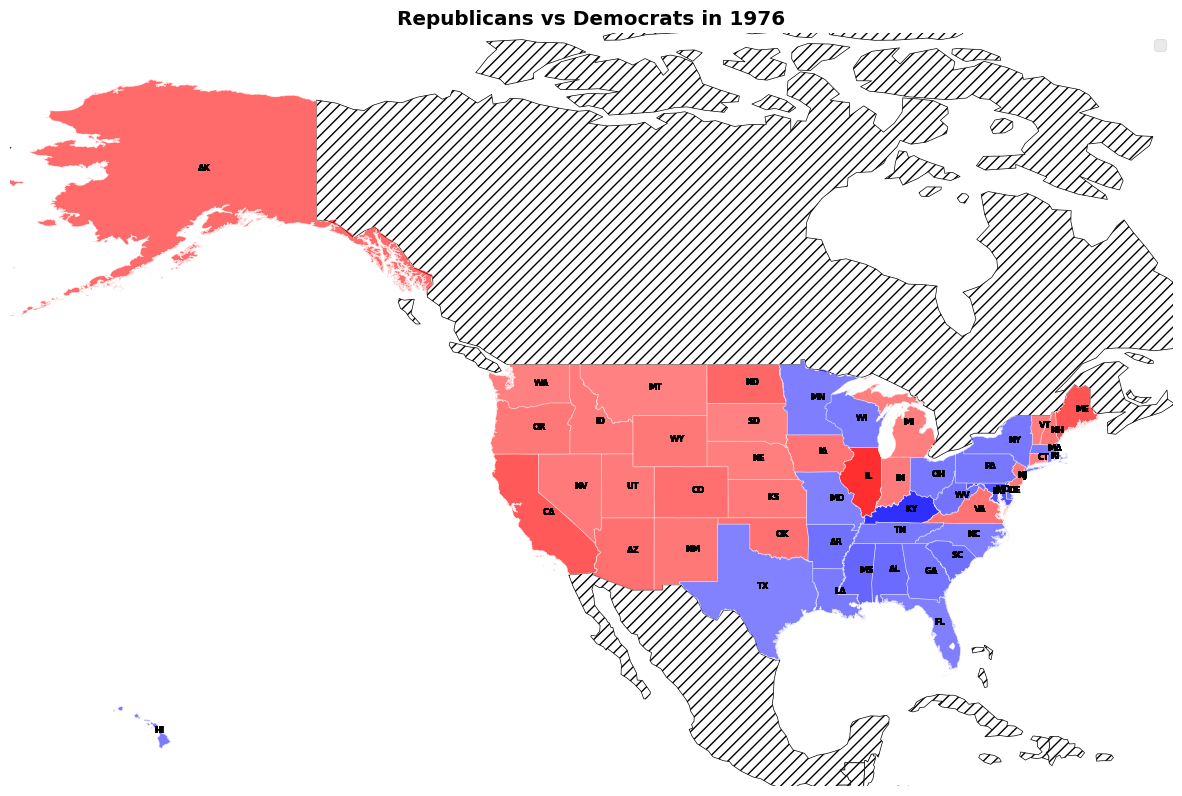

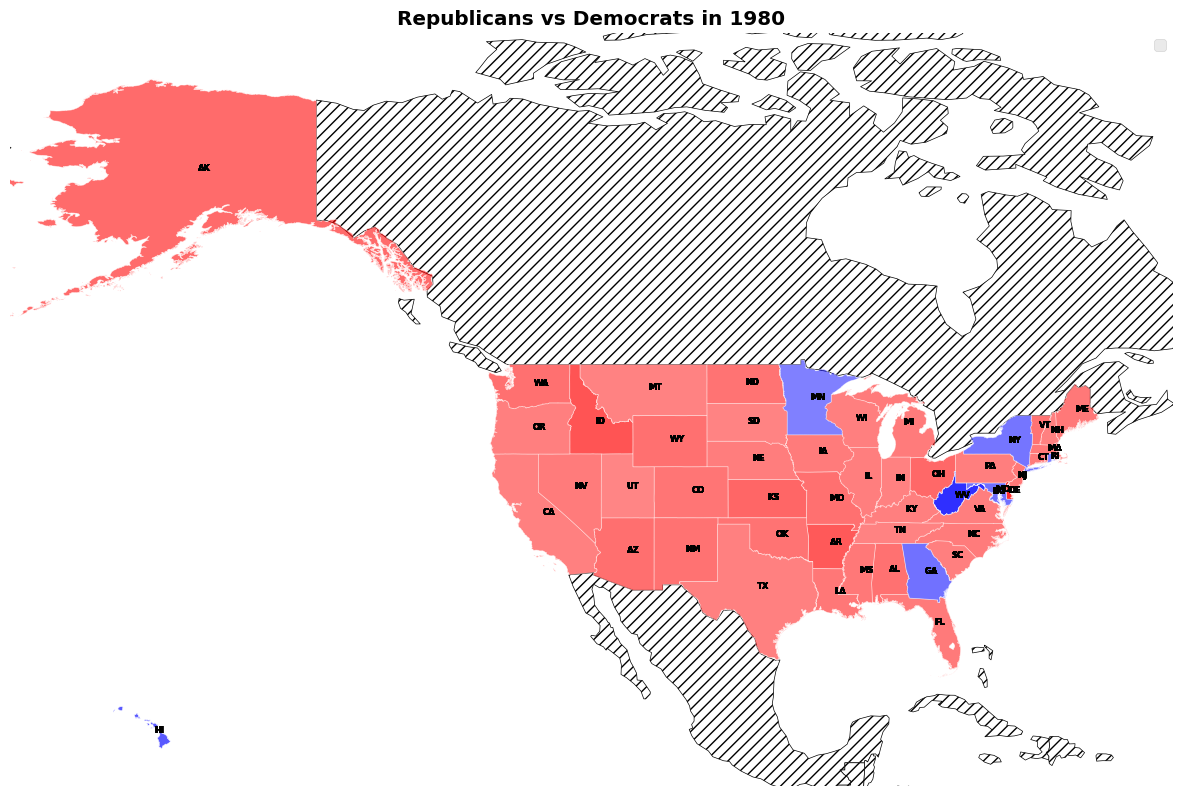

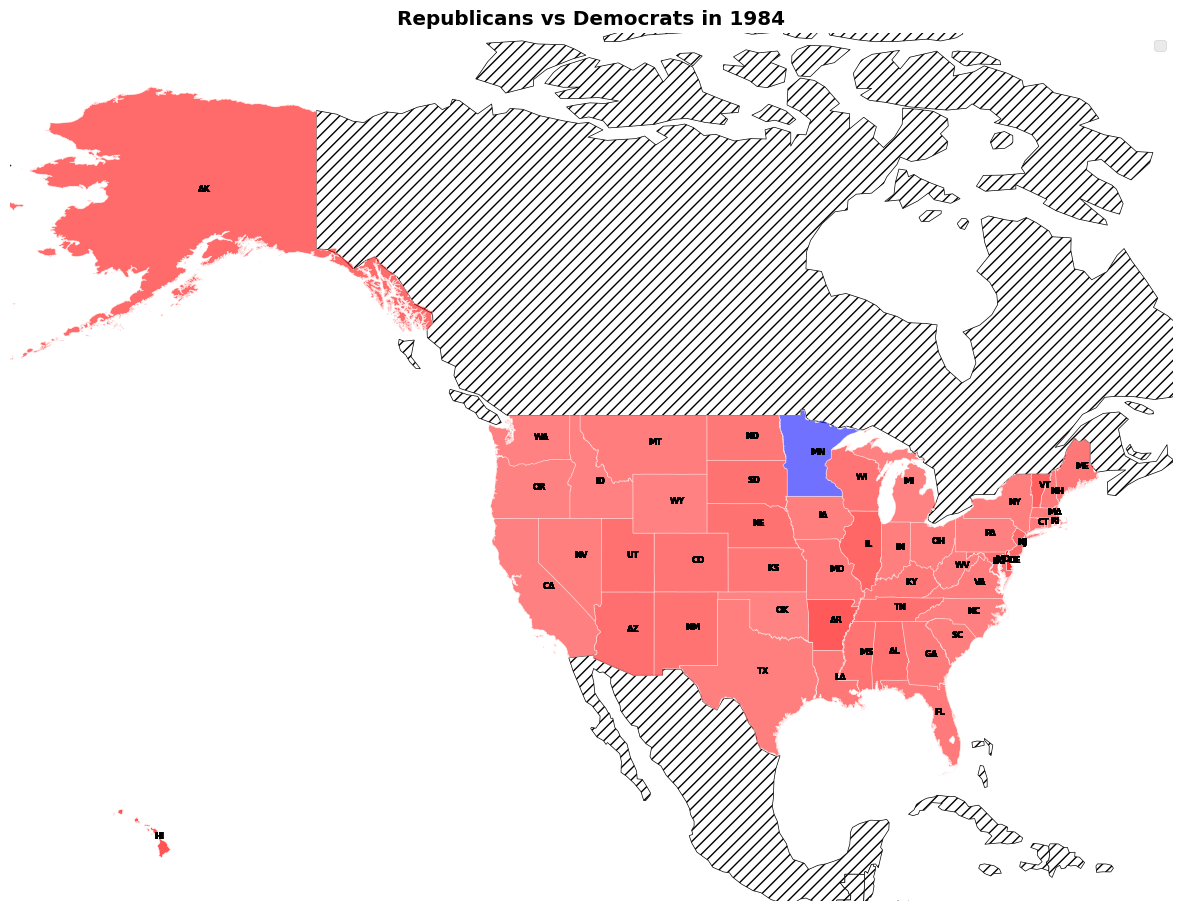

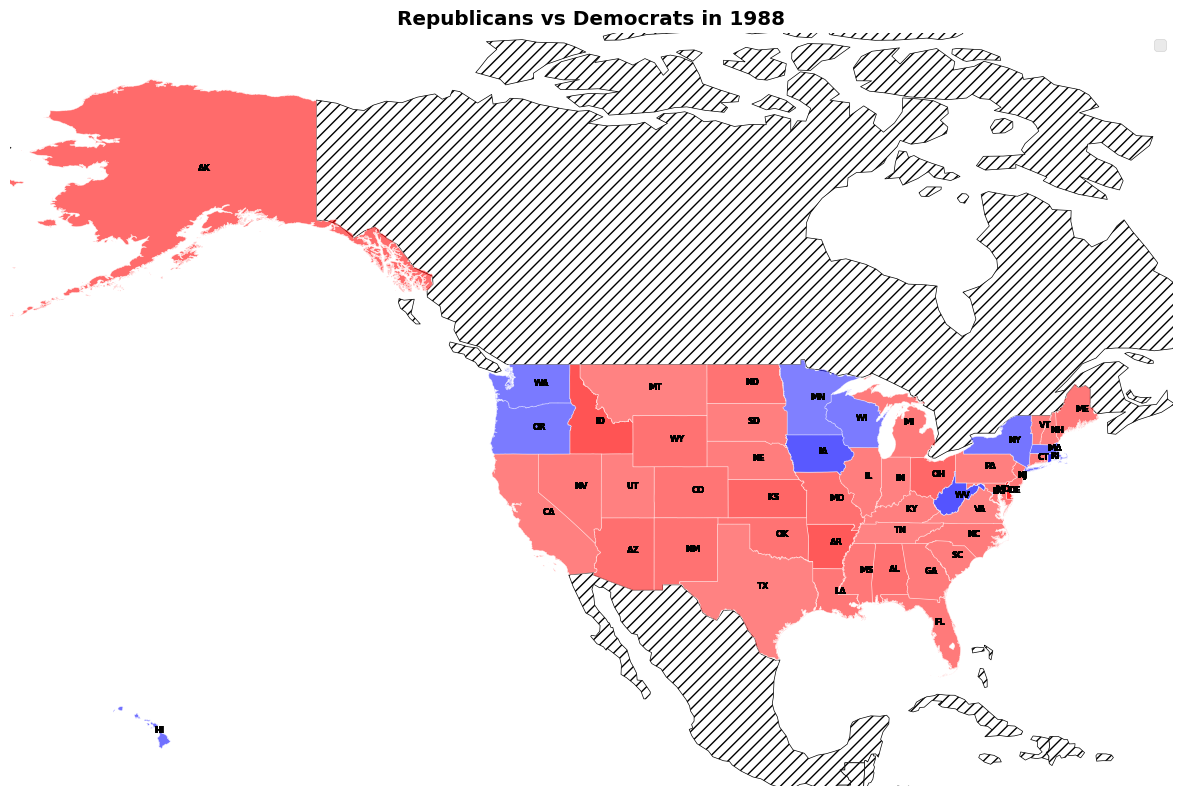

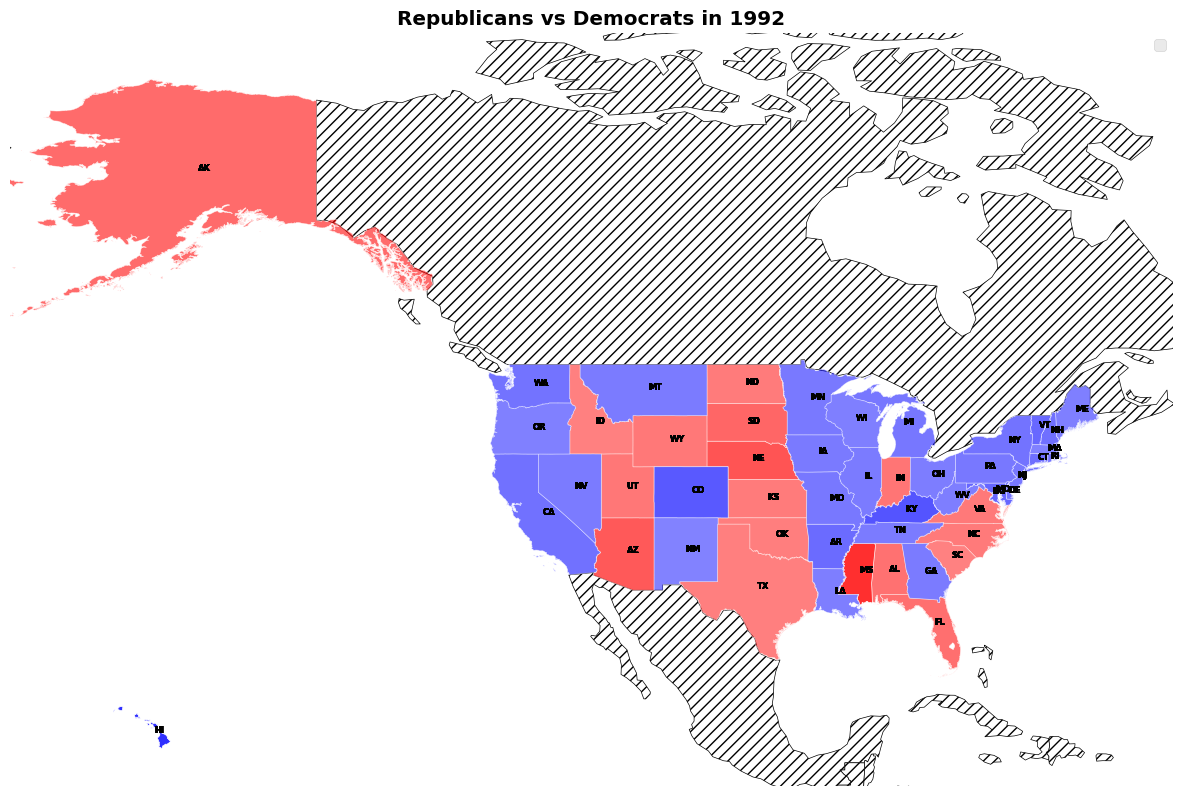

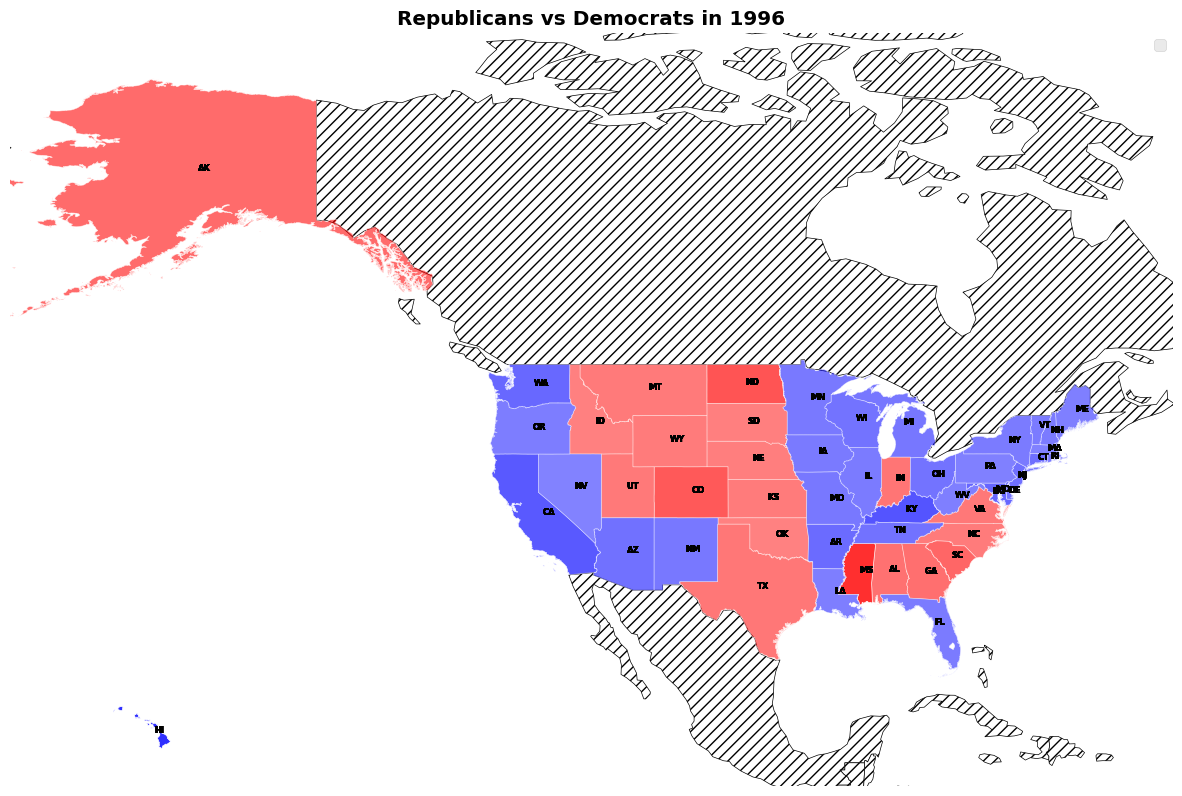

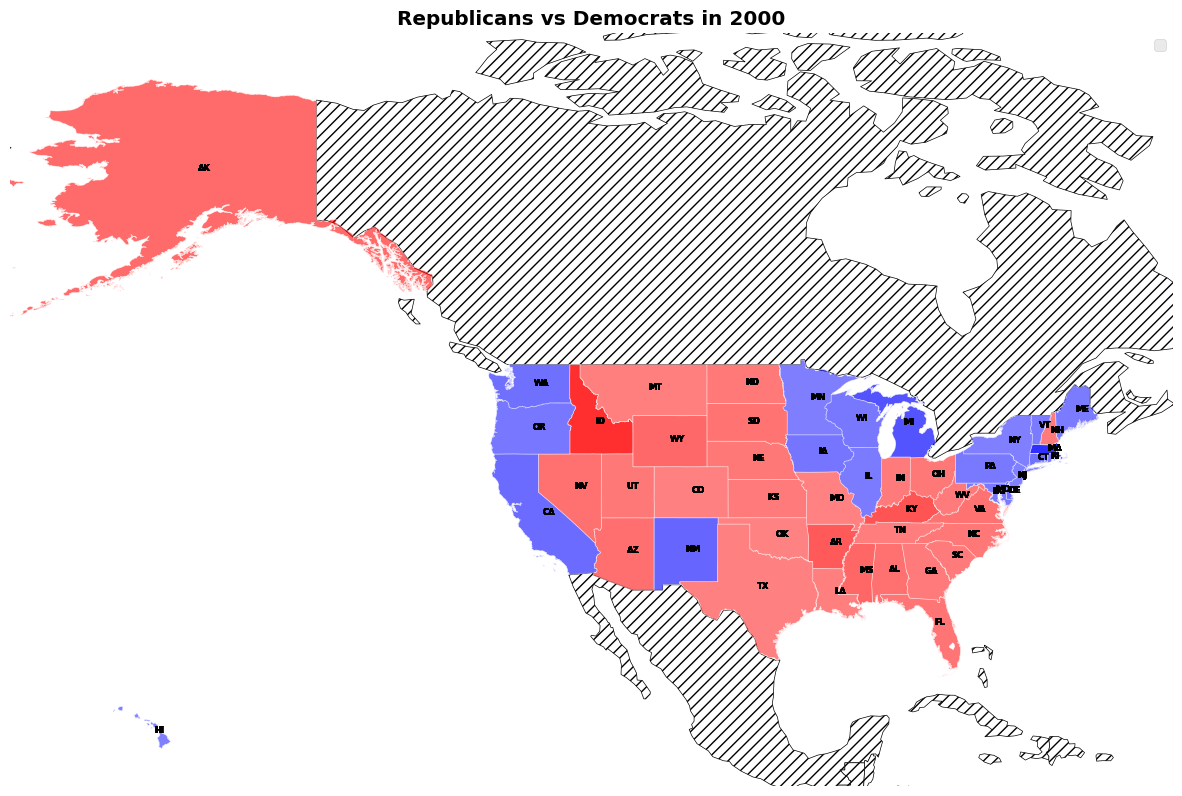

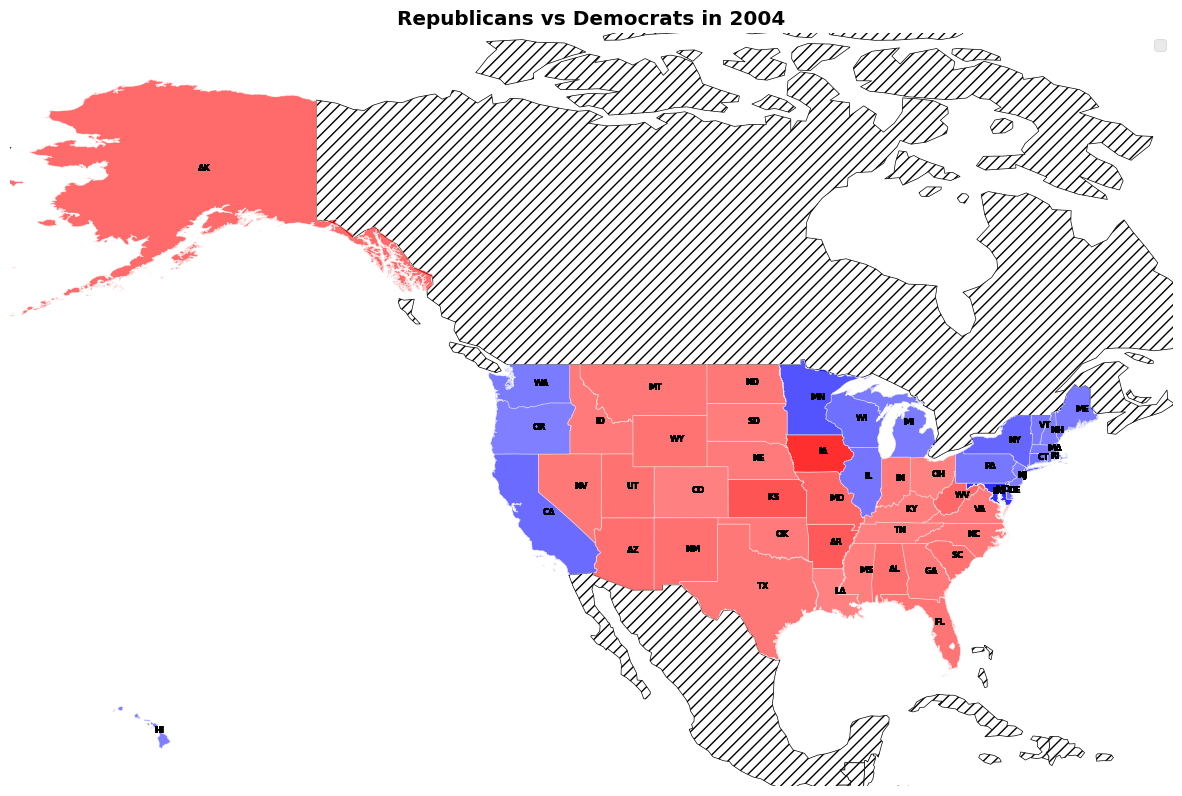

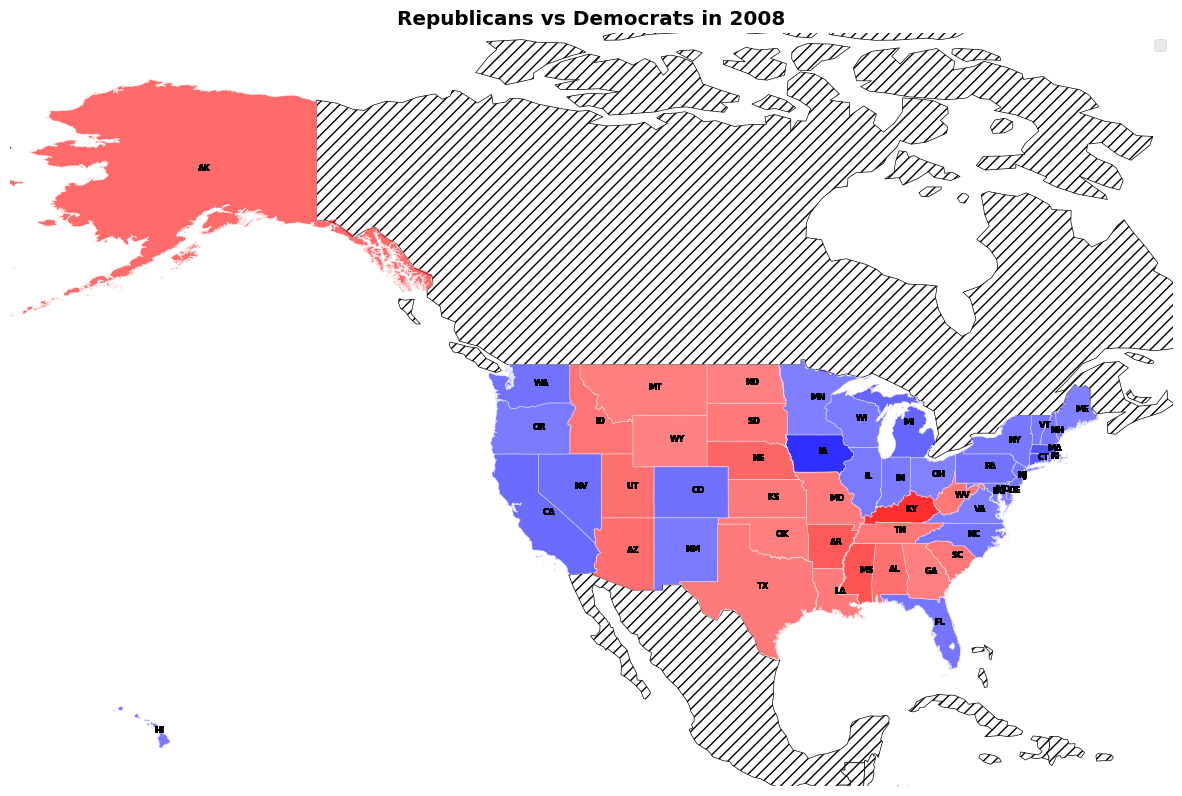

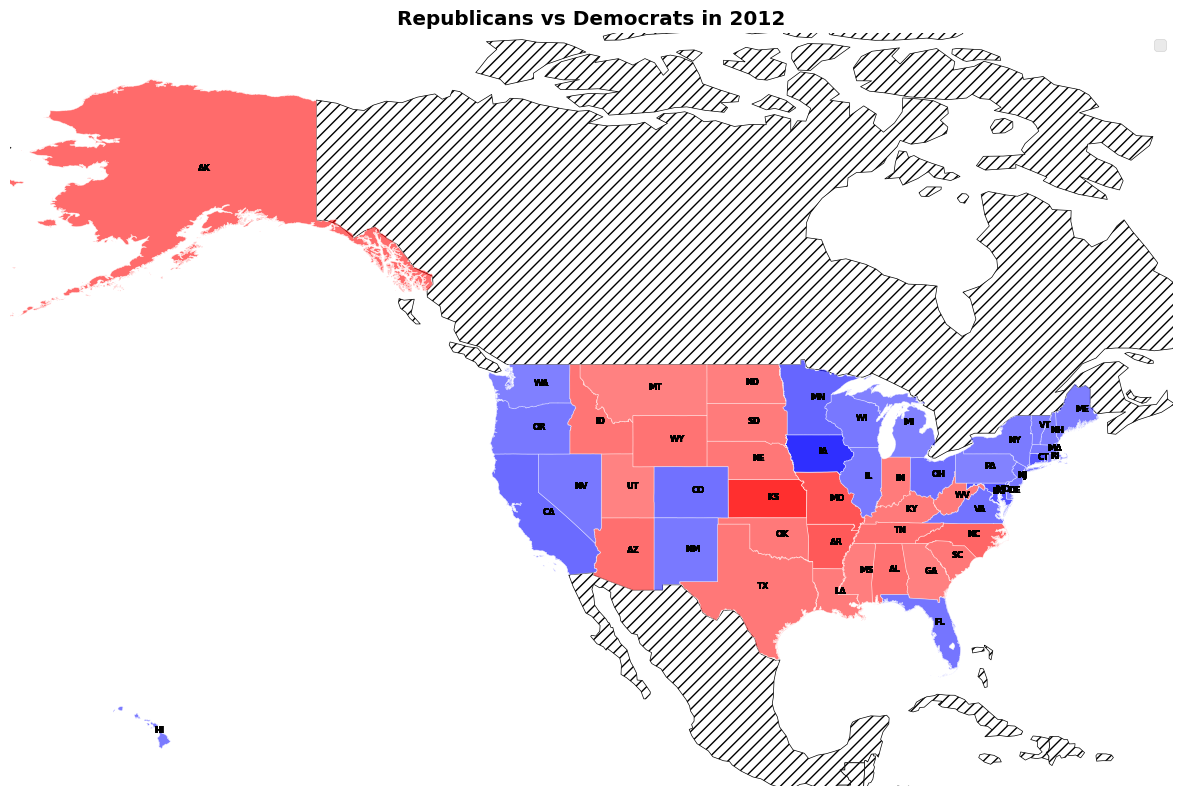

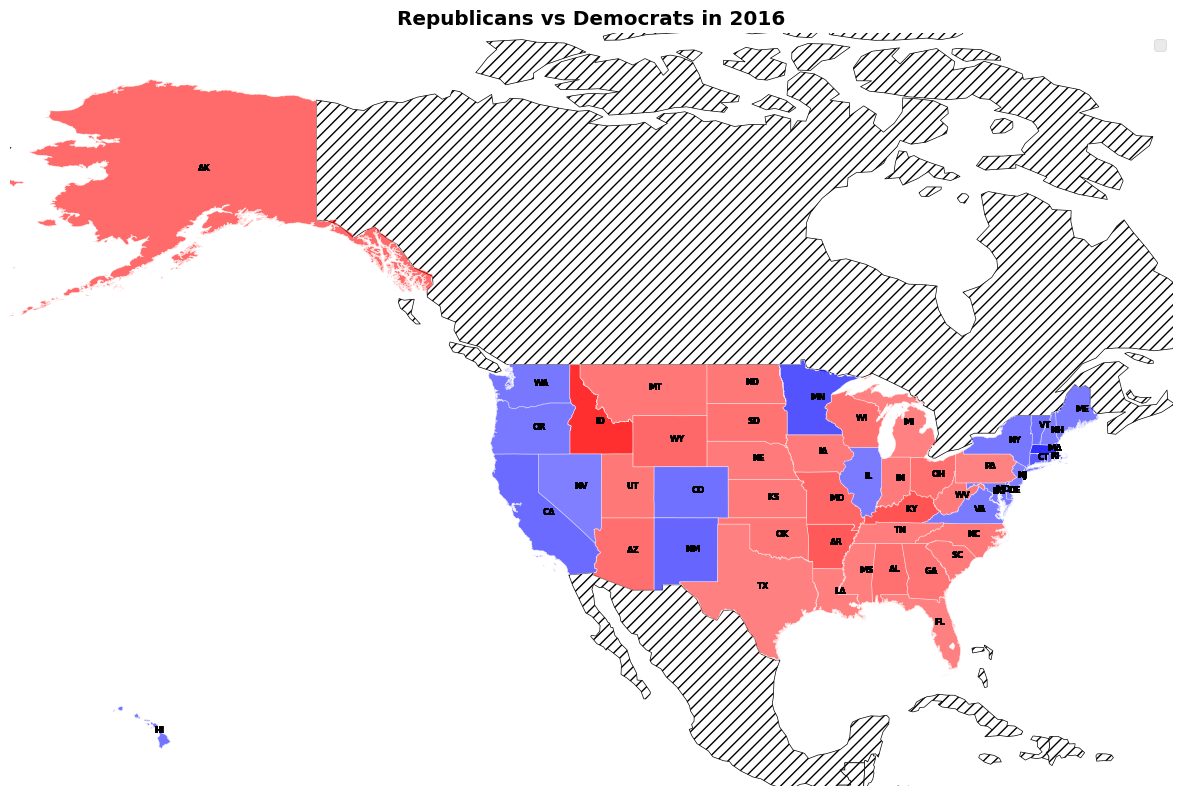

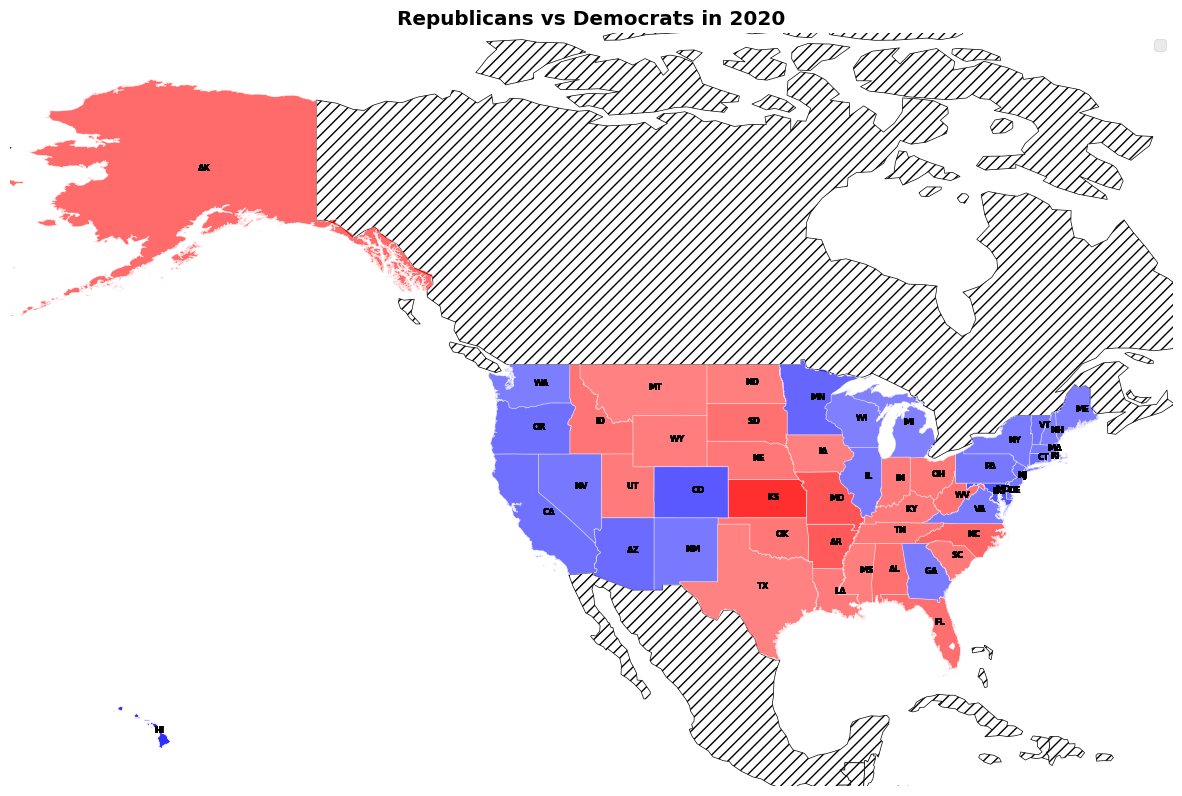

In [6]:
def year_results(year):
    fig,ax=plt.subplots(figsize=(15,15))
    world.query('name!="United States of America"').plot(ax=ax,color='white',ec='black',hatch="///")
    winners.query('year==@year').query('party_simplified=="REPUBLICAN"').plot(ax=ax,color='Red',ec='white',alpha=winners['percentage']/100) if winners.query('party_simplified=="REPUBLICAN" and year==@year').shape[0]>0 else None
    winners.query('year==@year').query('party_simplified=="DEMOCRAT"').plot(ax=ax,color='Blue',ec='white',alpha=winners['percentage']/100) if winners.query('party_simplified=="DEMOCRAT" and year==@year').shape[0]>0 else None
    winners.query('year==@year').query('party_simplified=="LIBERTARIAN"').plot(ax=ax,color='Yellow',ec='white',alpha=winners['percentage']/100) if winners.query('party_simplified=="LIBERTARIAN" and year==@year').shape[0]>0 else None
    winners.query('year==@year').query('party_simplified=="OTHER"').plot(ax=ax,color='Grey',ec='white',alpha=winners['percentage']/100) if winners.query('party_simplified=="OTHER" and year==@year').shape[0]>0 else None
    ax.set_title(f'Republicans vs Democrats in {year}',fontweight='bold')
    ax.legend(['REPUBLICAN','DEMOCRAT','LIBERTARIAN','OTHER'])
    ax.set_xlim(-170,-60)
    ax.set_ylim(16,75)
    ax.axis('off')
    
    for i in range(len(winners)):
        ax.text(winners['X'].iloc[i],winners['Y'].iloc[i],winners['state_po'].iloc[i],fontweight='bold',size=6)
    return plt.show()

    
for year in sorted(winners['year'].unique()):
    year_results(year)
    print('\n\n')

In [7]:
p=g.pivot_table(index=['year','state_po'],columns='party_simplified',values='percentage').reset_index()


fig=px.bar(p,x='state_po',y=['DEMOCRAT','REPUBLICAN'],barmode='group',animation_frame='year')
fig.update_layout(title=dict(text='Republicans vs Democrats by State per Year',font_family='Arial Black',font_color='black'),
                  width=1200,yaxis_range=[0,100],hovermode='x unified')
fig.update_xaxes(title_text='State')
fig.update_yaxes(title_text='Percent of total voters')
fig.show()